In [53]:
#!pip install biopython
from Bio import SeqIO 
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import numpy as np
import pandas as pd
import pysam
import time
import matplotlib.pyplot as plt

# Lecture des données
Ouverture et lecture des fichiers contenant les lectures et le génome de réference.

In [2]:
reads = list(SeqIO.parse('single_Pfal_dat.fq','fastq'))

In [3]:
Genome = list(SeqIO.parse('data','fasta'))

# Definition des fonctions utilisées

In [4]:
def complementInverse(w):
    wCI = []
    for i in range(len(w)):
        li = w[-i-1]
        if li not in "ATCG":
            raise Exception("Letter not in alphabet")
        lCI = 'A'*int(li=='T') + 'T'*int(li=='A') + 'C'*int(li=='G') + 'G'*int(li=='C')
        wCI.append(lCI)
    return ''.join(wCI)

In [5]:
def circularShift(T,k):
    if k<0:
        raise Exception("k must be positive")
    return T[k:]+T[0:k]

def BWT(S):
    if S[len(S)-1]!='$':
        S += '$'
        
    circShifts = []
    for k in range(len(S)):
        circShifts.append(circularShift(S,k))
    circShifts.sort()
    
    bwt = []
    for shift in circShifts:
        bwt.append(shift[len(S)-1])
        
    return bwt

In [6]:
def suffix_list(T): # O(n log n)
    """
    Compute the suffix list
    
    Args:
        T (str): string
    
    Return:
        list of strings: suffix list
    """
    suffix_list = [T[i:] for i in range(len(T))] # O(n)
    sorted(suffix_list,reverse=True) # O(n log n)
    return suffix_list

def suffix_table(T): # O(n log n)
    """
    Compute the suffix table
    
    Args:
        T (str): string
    
    Return:
        list of tuples (suffix,location): suffix table
    """
    suffix_list = [T[i:] for i in range(len(T))] 
    suffix_table = sorted((e,i) for i,e in enumerate(suffix_list))
    return suffix_table

def BWT_suffix_table(T,end_of_string="$"): # O(n log n)
    """
    Compute the BWT from the suffix table
    
    Args:
        T (str): string
        end_of_string (char): end of string character to append
    
    Return:
        bwt (str): BWT
    """
    if T[-1]!=end_of_string :
        T += end_of_string
    ST = suffix_table(T) # O(n log n)
    bwt = ""
    index = []
    for s,i in ST: # O(n)
        bwt += T[i-1]
        index.append(i-1)
    return bwt, index

In [7]:
from collections import Counter 

def occurrence_indexer(S):
    """
    Number of past occurrences of each char in S
    
    Args:
        S (str): string
        
    Return:
        table of int : number of past occurrences of the char
    """
    K = []
    last_index = {}
    for s in S:
        if s not in last_index: 
            last_index[s] = 0
        K.append(last_index[s])
        last_index[s] += 1
    return(K)

def last2first(counts,k,X):
    """
    k + nbr of occurrences of letters < X 
    
    Args:
        counts (Counter): nbr of each char in the text
        k : int
        X : char
        
    Return:
        int : k + nbr of occurrences of letters < X 
    """
    a = [counts[char] for char in counts if char < X]
    return k + sum(a)
    
def efficient_inverse_BWT(bwt,end_of_string="$"):
    """
    Inverse the BWT
    
    Args:
        bwt (str): bwt of a string T
        last_character (char): which is the end of string character?
    
    Return:
        T (str): BWT^{-1} of bwt
    """    
    K = occurrence_indexer(bwt)
    counts = Counter(bwt)
    X = bwt[0]
    k = K[0]
    S = end_of_string
    while X != end_of_string:
        S = X+S
        j = last2first(counts,k,X)
        X = bwt[j]
        k = K[j]
    return(S)

In [8]:
  def get_first_occurrence(L,X):
    for i,l in enumerate(L):
        if l == X:
            return(i)
        
def pattern_matching_BWT(T,pattern):
    """
    Search a patter in a String using the BWT
    
    Args:
        S (str): string
        pattern (str): pattern
    
    Return:
        bool: true if the pattern is in the string    
    """
    L,_ = BWT_suffix_table(T)
    K = occurrence_indexer(L)
    counts = Counter(L)
    e = 0
    f = len(L)
    i = len(pattern) - 1
    while e < f and i >= 0:
        X = pattern[i]
        first_occurence_in_L_ef = get_first_occurrence(L[e:f],X)
        if first_occurence_in_L_ef is None:
            return False
        else:
            r = first_occurence_in_L_ef+e
        #print(first_occurence_in_L_ef,L[e:f],r,X,L[r])
        
        last_occurence_in_L_ef = get_first_occurrence(L[e:f][::-1],X)
        if last_occurence_in_L_ef is None:
            return False
        else:
            s = f-last_occurence_in_L_ef-1
        #print(last_occurence_in_L_ef,L[e:f],s,X,L[s])
        
        e = last2first(counts,K[r],X)
        f = last2first(counts,K[s],X)+1
        i -= 1
        #print(r,s,e,f)
    return(i<0)



In [9]:
def rankBWT(bwt):
    """
    Number of past occurrences of each char in S
    
    Args:
        S (str): string
        
    Return:
        table of int : number of past occurrences of the char
    """
    K = []
    tot = {}
    for s in bwt:
        if s not in tot: 
            tot[s] = 0
        K.append(tot[s])
        tot[s] += 1
    return(K,tot)
    

In [10]:
def invBWT(bwt,A):
    A = sorted(A)
    #count = {a:0 for a in A}
    count = {}
    K = []
    for i in range(len(bwt)):
        if bwt[i] in count:
            count[bwt[i]] += 1
        else:
            count[bwt[i]] = 1
        K.append(count[bwt[i]])
    X = bwt[0]
    k = K[1]
    S = '$'
    while X != '$':
        S = X+S
        j = k
        i = 0
        while A[i] != X:
            j += count[A[i]]
            i += 1
        X = bwt[j]
        k = K[j]
    return S

In [11]:
def firstColMap(tots):
    """ Return a map from characters to the range of cells in the first
    column containing the character. 
    char : (first index, last index+1)"""
    first = {}
    totc = 0
    for c, count in sorted(tots.items()):
        first[c] = (totc, totc + count)
        totc += count
    return first

In [12]:
def searching(bwt, SAT, W):

    # Not case sensitive, make everything uppercase
    bwt = bwt.upper()
    W = W.upper()
    
    # Perdorm a BWT on text T and get the indexes corresponding to the Suffix Array of T
    #bwt, SAT = BWT_suffix_table(T)
    # LF mapping
    # F = sorted(bwt) # no need to store it
    rank, totCount = rankBWT(bwt)
    Fmap = firstColMap(totCount)
    del totCount

    
    #print('\nbwt :', sys.getsizeof(bwt),
    #'\nSAT :', sys.getsizeof(SAT),
    #'\nrank :', sys.getsizeof(rank),
    #'\nFmap :', sys.getsizeof(Fmap),)

    letter = W[-1] # last letter of the word W
    if letter not in Fmap:
        return -1, "Word not in text"
    fi, li = Fmap[letter] # find occurences of letter in F
    
    for i in range(2,len(W)+1):
        letter = W[-i] # search W by going backward through it
        if letter not in Fmap:
            return -1, "Word not in text"

        j = fi
        foundRankf = False
        while j < li:
            if bwt[j] == letter:
                if not foundRankf:
                    rankf = rank[j] # get the rank of the first occurence of letter (followed by W suffix)
                    foundRankf = True
                rankl = rank[j] # get the rank of the last occurence of letter (followed by W suffix)
            j += 1
        
        if not foundRankf:
            return -1, "Word not in text"
        
        fi, li = Fmap[letter] # find occurences of letter in F
        fi += rankf # find first occurence of letter in F (followed by W suffix)
        li = fi + rankl-rankf +1 # find last occurence of letter in F (followed by W suffix)

    return [x+1 for x in SAT[fi:li]]
    

In [13]:
def searchWord(cutSeq, n, k, words):

    bwtSeq = []
    satSeq = []
    for s in cutSeq:
        bwt, sat = BWT_suffix_table(s)
        bwtSeq.append(bwt)
        satSeq.append(sat)

    foundRead = []
    for i in range(len(cutSeq)):
        res = searching(bwtSeq[i], satSeq[i], words)
        if res[0] != -1 :
            resi = [x+i*(n-k) for x in res]
            foundRead += resi

    return np.unique(foundRead)

In [14]:
def GenomeBWT(genome):
    bwtGen = []
    satGen = []
    
    wholeGenomeCutted = []
    n = int(1e4)
    overlap = 100
    for i in range(len(Genome)):
        chromosome = Genome[i].seq.upper()
        cutChr = cutSequence(chromosome, n, overlap)
        wholeGenomeCutted.append(cutChr)
        
    for c in range(len(genome)):
        print('chr',c)
        chromosome = wholeGenomeCutted[c]
        bwtChr = []
        satChr = []
        for seq in chromosome:
            bwt, sat = BWT_suffix_table(seq)
            bwtChr.append(bwt)
            satChr.append(sat)
        bwtGen.append(bwtChr)
        satGen.append(satChr)
    return (bwtGen,satGen)

In [15]:
def searchChr(bwtChr,satChr, word):
    n = int(1e4)
    overlap = 100

    foundRead = []
    for i in range(len(bwtChr)):
        res = searching(bwtChr[i], satChr[i], word)
        if res[0] != -1 :
            resi = [x+i*(n-overlap) for x in res]
            foundRead += resi

    return np.unique(foundRead)

In [16]:
def searchGen(bwtGen,satGen, word):
   
    foundGen = {}
    for i in range(len(bwtGen)):
        foundChr = searchChr(bwtGen[i],satGen[i], word)
        foundGen[i] = foundChr
        
    return foundGen

In [17]:
def getKmers(read, k):
    read = str(read)
    kmers = []
    iF = 0
    iL = iF + k

    Continuer = True

    while Continuer:
        if iL >= len(read):
            Continuer = False
            iL = len(read)
        kmers.append(read[iF:iL])
        iF +=1
        iL = iF + k
        if Continuer and iF >= len(read):
            Continuer = False
            
    return kmers

In [18]:
def SWmatrix2strings(S,T,D,F):
    """
    Smith-Waterman matrix to aligned strings

    Args:
        S (str): first string
        T (str): second string
        D (np.array or list of lists): Decision matrix

    Returns:
        S_aligned (str): first string aligned
        T_aligned (str): second string aligned
        
    """    
    S_WITH_GAP = -1
    T_WITH_GAP = 1
    S_T_ALIGN = 0
    i,j = np.unravel_index(F.argmax(),F.shape)
    end = (i,j)
    S_aligned = ""
    T_aligned = ""
    while i > 0 and j > 0:
        #print(i,j,T[j-1],S[i-1],D[i,j])
        #print(S_aligned,T_aligned)
        #print(S[i-1], S_aligned)
        if D[i,j] == S_WITH_GAP:
            S_aligned = S[i-1]+S_aligned
            T_aligned = "_"+T_aligned
            #print(S_aligned,T_aligned)
            i -= 1
        elif D[i,j] == T_WITH_GAP:
            T_aligned = T[j-1]+ T_aligned
            S_aligned = "_"+S_aligned
            #print(S_aligned,T_aligned)
            j -= 1
        elif D[i,j] == S_T_ALIGN:
            S_aligned = S[i-1] + S_aligned
            T_aligned = T[j-1] + T_aligned
            #print(S_aligned,T_aligned)
            j -= 1
            i -= 1
        #elif D[i,j] == NO_ALIGN:
        else:
            break
    start = (i,j)
    return(S_aligned,T_aligned,start,end)

def Smith_Waterman(S,T,return_matrix=False):
    """
    Needleman-Wunch 

    Args:
        S (str): first string
        T (str): second string
        return_matrix (bool): If true return matrix, else return the aligned strings

    Returns:
        F,D (np.array, np.array): If return_matrix is true F is the score matrix and D the decision matrix
        S_aligned, T_aligned (str,str): If return_matrix is false first and second strings aligned
        
    """
    T_WITH_GAP = 1
    S_WITH_GAP = -1
    S_T_ALIGN = 0
    NO_ALIGN = 2
    decision = [T_WITH_GAP,S_WITH_GAP,S_T_ALIGN,NO_ALIGN]
    F = np.zeros((len(S)+1,len(T)+1))
    D = np.zeros((len(S)+1,len(T)+1))
    D[0,1:] = T_WITH_GAP 
    D[1:,0] = S_WITH_GAP 
    for i in range(1,len(S)+1):
        for j in range(1,len(T)+1):
            comparison = int(S[i-1]==T[j-1])*2-1
            options = [F[i,j-1] - 1, F[i-1,j] - 1, F[i-1,j-1] + comparison, 0]
            F[i,j] = options[0]
            D[i,j] = T_WITH_GAP
            for o,val in enumerate(options):
                if val > F[i,j]:
                    F[i,j] = val
                    D[i,j] = decision[o]
    if return_matrix:
        return F,D
    else:
        return SWmatrix2strings(S,T,D,F)

In [19]:
def cutSequence(seqToCut, n, k):
    cutSeq = []
    iF = 0
    iL = iF + n

    Continuer = True

    while Continuer:
        if iL >= len(seqToCut):
            Continuer = False
            iL = len(seqToCut)
        cutSeq.append(seqToCut[iF:iL])
        iF += n - k
        iL = iF + n -1
        if Continuer and len(seqToCut) - iF <= k :
            Continuer = False
            
    return cutSeq

In [49]:
def MappingKmers(Read,ReadSeq,bwtGen,satGen, iCh,k, CompInv=False):
    
    KmersRead = getKmers(ReadSeq, k)
    uniqueKmers = np.unique(KmersRead)
    kmerDict = {k : [] for k in uniqueKmers}
    for i in range(len(KmersRead)):
        kmerDict[KmersRead[i]].append(i)
    
    ChrKmersPos = []
    #ChrKmersFound = {}
    ChrKmersFreq = {}
    for w in uniqueKmers:
        foundChr = searchChr(bwtGen[iCh],satGen[iCh], w)
        #ChrKmersFound[w] = foundChr
        ChrKmersFreq[w] = len(foundChr)
        for i in foundChr:
            ChrKmersPos.append((w,i))
            
            
    # Filter out very frequent k-mers
    ChrKmersPosFilt = []
    threshold = np.percentile(list(ChrKmersFreq.values()),75)
    for t in ChrKmersPos:
        if ChrKmersFreq[t[0]] < threshold:
            ChrKmersPosFilt.append(t)

    # Sort k-mers along chromosome
    ChrKmersPosFiltdf = pd.DataFrame(ChrKmersPosFilt, columns=['K-mer','i']).sort_values('i')
    SortedKmers = list(ChrKmersPosFiltdf.loc[:,'K-mer'])

    # Chromosom-read k-mers correspondance  
    corrRead = [] # indices des k-mers de la lecture mis en correspondance avec les k-mers du génome
    i = -1
    for k in SortedKmers: # Pour chaque k-mer dans le génome
        i += 1
        listI = kmerDict[k] # liste des positions possibles dans la lecture
        # Si qu'une position ou que début de la mise en correspondance 
        # ou qu'on a déjà une fin de lecture mis en correspondance juste avant
        if len(listI) == 1 or len(corrRead) == 0 or listI[-1]-corrRead[-1]<=0:
            corrRead.append(listI[0]) # on met en correspondance k du génome avec la première occurence de k dans le read
        else:
            # différence entre les posible occurences de k dans read 
            # avec l'index de la dernière correspondance faite
            dist = np.array(listI)-corrRead[-1]
            j = 0
            # on cherche l'occurence pouvant étant après l'index de la dernière correspondance faite
            # et la plus proche de celle-ci
            while dist[j]<=0:
                j+=1

            corrRead.append(listI[j])    
    
    x = corrRead
    y = list(ChrKmersPosFiltdf.loc[:,'i'])
    
    return (x,y)

In [67]:
def findRead(x,y,Read,ReadSeq,Genome,iCh,CompInv=False):
    
    yRange = (min(y),max(y))
    ySpan = yRange[1]-yRange[0]
    epsilon = len(ReadSeq)*2

    mi = yRange[0]
    ma = mi+epsilon
    i = 0
    yMov = [0]*ySpan
    for j in range(len(y)):
        if y[j] < ma:
            yMov[i] += 1
        else:
            lastyMov = yMov[i]
            while y[j] >= ma:
                i += 1
                mi += 1
                ma += 1
                yMov[i] = yMov[i-1]
                jMi = j-yMov[i-1]
                while y[jMi] < mi:
                    yMov[i] -= 1 
                    jMi += 1
            yMov[i] += 1
     
    # Supposons que la lecture ne peux pas être présente plus d'une fois dans un chromosome.
    iStart = yMov.index(max(yMov))+yRange[0]
    iEnd = iStart + epsilon
    iStart -= int(len(ReadSeq)/2)
    iEnd += int(len(ReadSeq)/2)
    #print(iStart)
    #print(iEnd)
    
    S = str(Genome[iCh].seq)[iStart:iEnd].upper()
    T = ReadSeq
    F,D = Smith_Waterman(S,T,True)
    seqChr,seqRead,istart,iend = SWmatrix2strings(S,T,D,F)
    
    mappedTo = (istart[0]+iStart,iend[0]+iStart)
    Fscore = np.amax(F)
    #print(Fscore)
    
    if CompInv:
        flag = 16
    else:
        flag = 0
    this = np.reshape([flag,iCh,mappedTo[0],mappedTo[1],Fscore],(1, 5))
    thisMapping = pd.DataFrame(this,index = [Read.id],columns=['Flag','chr', 'iStart', 'iEnd', 'Fscore'])
    
    return thisMapping

In [83]:
def MappingOneRead(Genome,reads,iRead,k,bwtGen,satGen,CompInv=False,temp=False):
    # on va chercher la bonne lecture en prenant la complémentaire inverse si CompInv = True
    Read = reads[iRead]
    if CompInv:
        ReadSeq = complementInverse(str(Read.seq).upper())
    else:
        ReadSeq = str(Read.seq).upper()
        
    # on récupère la liste des k-mers de la lecture    
    KmersRead = getKmers(ReadSeq, k)
    uniqueKmers = np.unique(KmersRead)
    kmerDict = {k : [] for k in uniqueKmers}
    for i in range(len(KmersRead)):
        kmerDict[KmersRead[i]].append(i)
        
    # initalisation des variables de stockage de temps de calcul
    timeMapKmers = []
    timeFindRead = []    
    # initalisation de la variable de stockage de l'alignement  
    storeMapping = pd.DataFrame(columns=['Flag','chr', 'iStart', 'iEnd', 'Fscore'])
    # pour chaque chromosome
    for iCh in range(len(Genome)):
        #print(iCh)
        t0 = time.perf_counter()
        x,y = MappingKmers(Read,ReadSeq,bwtGen,satGen, iCh,k,CompInv) # où sont les k-mers dans le génome ?
        t1 = time.perf_counter()
        A = findRead(x,y,Read,ReadSeq,Genome,iCh,CompInv) # il y a-t-il des zones du génome pouvant être une lecture ?
        t2 = time.perf_counter()
        print(A)
        timeMapKmers.append(t1-t0)
        timeFindRead.append(t2-t1)
        # on va considérer qu'il n'existe qu'une bonne occurence de la lecture sur le génome
        if int(A.loc[:,'Fscore']) >= 90:
            storeMapping = storeMapping.append(A)
            break
            
    if temp:
        return (storeMapping,timeMapKmers,timeFindRead)
    return storeMapping

# Description de l'algorithme

1. Une transformée de Burrows-Wheeler (BWT) est appliquée au génome de référence. 
2. La lecture est décomposée en k-mers.
3. Les différents k-mers présents dans la lecture sont recherchées et positionnées dans le génome de référence en utilisant la BWT et la table de suffixes des chromosomes composants le génome.
4. La fréquence de chaque k-mers dans le génome est calculée et les k-mers très fréquents (suppérieur au $75^e$ percentile) sont exclus de l'étude.
5. On met en correspondance les position des k-mers dans le génome (y) avec les position des k-mers dans la lecture (x)
6. Afin de détecter la présence de la lecture dans le génome, on cherche une zone de y où l'on va avoir la présence d'une majorité des positions de k-mers sur x. Pour cela on récupère le nombre de points tels que $y\in[a,b]$ avec $[a,b]$ une fenêtre glissante le long de y. On suppose qu'une lecture peut être présente dans le génome lorque l'on a un nombre de points élevé dans la fenêtre glissante.
7. On réalise un alignement de cette zone 

# Création de la variable de stockage

In [22]:
storeMapping = pd.DataFrame(columns=['Flag','chr', 'iStart', 'iEnd', 'Fscore'])

# Préprocessing du génome

On applique une transformée de Burrows-Wheeler (BWT) à tout le génome en le séparant en plusieurs sous séquences pour ne pas surcharger la mémoire vive :

In [23]:
bwtGen, satGen = GenomeBWT(Genome)

chr 0
chr 1
chr 2
chr 3
chr 4
chr 5
chr 6
chr 7
chr 8
chr 9
chr 10
chr 11
chr 12
chr 13
chr 14


Cette transformée est couteuse et n'est donc effectuée qu'une fois pour tout le génome.

# Recherche d'une lecture dans le génome

On prend une des lectures (ici la première)

In [24]:
iRead = 0
k = 10
CompInv = False

In [65]:
storeMapping,timeMapKmers,timeFindRead = MappingOneRead(Genome,reads,iRead,k,bwtGen,satGen,CompInv,True)

NameError: name 'satGenCompInv' is not defined

Text(0, 0.5, 'Time taken to find read (s)')

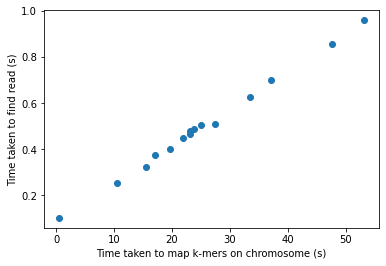

In [58]:
plt.scatter(timeMapKmers,timeFindRead)
plt.xlabel("Time taken to map k-mers on chromosome (s)")
plt.ylabel("Time taken to find read (s)")

L'étape prenant le plus de temps est de trouver toutes les occurences des k-mers sur les chromosomes pouvant aller jusqu'à 1min pour certain chromosomes. On a une relation $1/60$ entre le temps de mapping des k-mers et le positionnement d'un lecture à partir de ce mapping.

Idem pour le complément inverse

In [63]:
CompInv = True
MappingOneRead(Genome,reads,iRead,k,bwtGen,satGen,CompInv)

                    chr    iStart      iEnd  Fscore
NC_004325.2-100000  0.0  131734.0  131834.0    98.0


(                    chr    iStart      iEnd  Fscore
 NC_004325.2-100000  0.0  131734.0  131834.0    98.0,
 [9.766329269999915],
 [0.25863098799982254])

# Comparaison à la vérité terrain
Ouverture du fichier .bam :

In [99]:
samfile = pysam.AlignmentFile('./single_Pfal_dat.bam', 'rb')
align = samfile.fetch(until_eof=True)

Cherchons les alignements de la lecture traitée

In [143]:
for a in align:
    if a.qname == Read.id:
        print(a)


On retrouve un résultat similaire : avec la complementaire inverse de la lecture (flag = 16) alignée sur le chromosome 1 (#0) à la position $131735$.

Pour rendre le résultat plus juste il faudrait revoir la détection de read à partir du mapping des k-mers;

# Mapping pour plusieurs lectures

In [87]:
TimeRead = []
rangeiRead = range(5)
for iRead in rangeiRead:
    t0 = time.perf_counter()
    k = 10
    CompInv = False
    A = MappingOneRead(Genome,reads,iRead,k,bwtGen,satGen,CompInv)
    CompInv = True
    B = MappingOneRead(Genome,reads,iRead,k,bwtGen,satGen,CompInv)
    if int(A.loc[:,'Fscore'])>int(B.loc[:,'Fscore']):
        storeMapping = storeMapping.append(A)
    else:
        storeMapping = storeMapping.append(B)
    t1 = time.perf_counter()
    TimeRead.append(t1-t0)

0
                    Flag  chr    iStart      iEnd  Fscore
NC_004325.2-100000   0.0  0.0  104204.0  104297.0    37.0
1
                    Flag  chr    iStart      iEnd  Fscore
NC_004325.2-100000   0.0  1.0  213397.0  213426.0    16.0
2
                    Flag  chr    iStart      iEnd  Fscore
NC_004325.2-100000   0.0  2.0  665540.0  665613.0    35.0
3
                    Flag  chr    iStart      iEnd  Fscore
NC_004325.2-100000   0.0  3.0  135268.0  135334.0    22.0
4
                    Flag  chr     iStart       iEnd  Fscore
NC_004325.2-100000   0.0  4.0  1066826.0  1066903.0    25.0
5
                    Flag  chr    iStart      iEnd  Fscore
NC_004325.2-100000   0.0  5.0  552090.0  552187.0    29.0
6
                    Flag  chr    iStart      iEnd  Fscore
NC_004325.2-100000   0.0  6.0  855730.0  855826.0    34.0
7
                    Flag  chr    iStart      iEnd  Fscore
NC_004325.2-100000   0.0  7.0  741449.0  741530.0    33.0
8
                    Flag  chr    iStart      iEnd 

TypeError: cannot convert the series to <class 'int'>

In [88]:
storeMapping

,chr,iStart,iEnd,Fscore,Flag
NC_004325.2-100000,0.0,104204.0,104297.0,37.0,0.0
NC_004325.2-100000,0.0,131734.0,131834.0,98.0,16.0
NC_004325.2-99999,0.0,143900.0,144000.0,98.0,0.0
NC_004325.2-99999,0.0,109528.0,109621.0,31.0,16.0
NC_004325.2-99998,0.0,471737.0,471837.0,100.0,0.0
NC_004325.2-99998,0.0,148724.0,148801.0,26.0,16.0
NC_004325.2-99997,0.0,65426.0,65524.0,98.0,0.0
NC_004325.2-99997,0.0,458641.0,458740.0,49.0,16.0
NC_004325.2-99996,0.0,274963.0,275067.0,26.0,0.0
NC_004325.2-99996,0.0,152677.0,152777.0,98.0,16.0


In [145]:
align = samfile.fetch(until_eof=True)
for a in align:
    print(a.qname)

Le temps d'execution reste encore bien trop élevé pour pouvoir traiter toutes les lectures en un temps raisonnable. De plus, la méthode de détection d'une lecture dans les k-mers mappé sur le génome pourrait être retravaillé pour être plus précis et éventuellement pouvoir détecter plusieurs zones où une lecture pourrait être alignée. 

Un travail sur la sortie des données serait aussi à faire, pour avoir des données d'alignement bien formmatées et qui puissent être comparées au fichier bam fournis.